In [1]:
import riptide
import os
import matplotlib.pyplot as plt
import numpy as np
import sps_common.barycenter as barycenter
from datetime import datetime, timezone
import h5py
from astropy.time import Time
from FFA_search_CHIMEPulsar import FFA_search_CHIMEPulsar
TSAMP = 0.00032768

In [21]:
# filename = 'B0301+19_60318_powdm15.66.npz'
# filename = 'J1000+08_60337_powdm21.npz'
filename = 'J1824-0127_60339_powdm63.2.npz'

data = np.load(filename, allow_pickle = True)

# Assign the values to variables
ts = data['ts']
mjd_start = data['mjd_start']
date = Time(mjd_start, format='mjd').to_datetime()
length = data['length']
obs_middle = data['obs_middle']
obs_middle_datetime = data['obs_middle_datetime']
obs_start_datetime = data['obs_start_datetime']
ra = data['ra']
dec = data['dec']
dm = data['dm']


expected_period = 2.499468698918439
birdies = []
stack_bool = True
best_period_profile_bool = True
# Close the file (optional, ensures resources are freed)
data.close()

In [22]:
FFA_search_CHIMEPulsar(ts, dm, date, ra, dec, expected_period, birdies, stack_bool, best_period_profile_bool)

[2024-12-15 10:03:12,275] INFO::barycenter: RA (J2000) : 12h13m21.50070195s
[2024-12-15 10:03:12,277] INFO::barycenter: Dec (J2000) : 1d12m48.59196472s
[2024-12-15 10:03:12,278] INFO::barycenter: Topocentric MJD : 60339.73600142065 - 60339.74571045769
[2024-12-15 10:03:12,849] INFO::barycenter: mean barycentric velocity (fraction of speed of light) = 7.945628618089896e-05


Barycentric Peak(period=2.4996555461328644, freq=0.4000551202132899, width=4, ducy=0.0020844189682126106, iw=3, ip=6494, snr=10.326997756958008, dm=None)
Finished making periodograms for all DM trials
Time: 0.1825413703918457 s
Wrote stack file at: /scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_276.22_1.21_4/stack_276.22_1.21.hdf5
Wrote profile at /scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_276.22_1.21_4/profile_276.22_1.21_20240130.npz
Write time: 0.004446268081665039


In [23]:
directory_name = f"./FFA_search_CHIMEPulsar_test/stack_{np.round(ra,2)}_{np.round(dec,2)}"
stack_name = f"stack_{np.round(ra,2)}_{np.round(dec,2)}.hdf5"
file_path = os.path.join(directory_name, stack_name)


with h5py.File(file_path, 'r') as hf:
    snrs = hf["snrs"][:]
    periods = hf["periods"][:]
    dm = hf.attrs["dm"]
    widths = hf.attrs["widths"]
    foldbins = hf["foldbins"][:]
    stack_length = hf.attrs["stack_length"]

print("N period trials:", len(periods))
print("Boxcar width trials:",widths)
print("Stack length:",stack_length)

N period trials: 12829
Boxcar width trials: [ 1  2  3  4  6  9 13 19 28 42 63 94]
Stack length: 9


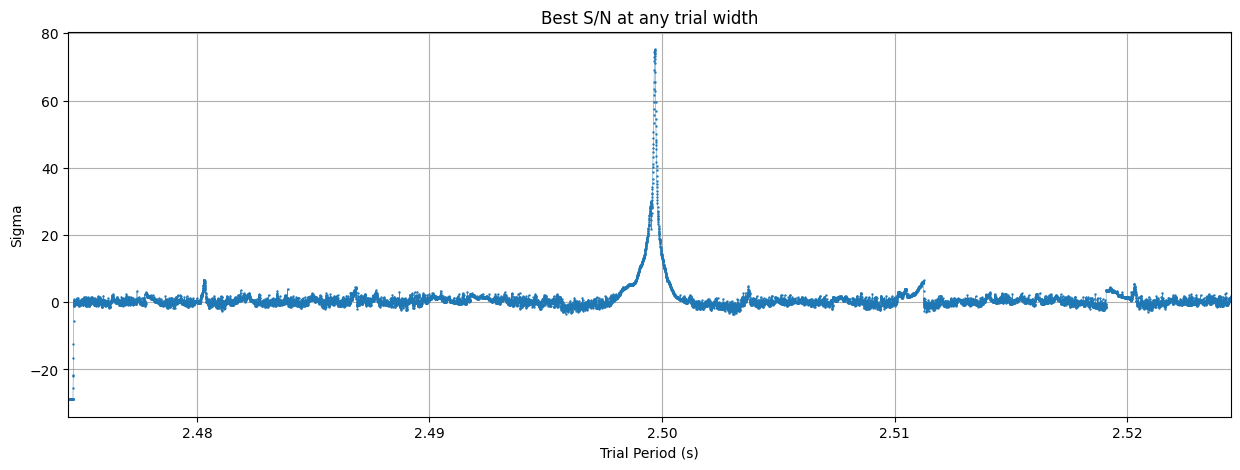

In [24]:
pgram = riptide.Periodogram(widths, periods, foldbins, snrs, {})
pgram.metadata['dm'] = dm
pgram.metadata['tobs'] = len(ts)*TSAMP

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pgram.periods, pgram.snrs.max(axis=1),linewidth=0.3, marker='o', markersize=0.7)
plt.title("Best Sigma at any trial width")
plt.xlim(min(pgram.periods),max(pgram.periods))
plt.xlabel("Trial Period (s)")
plt.ylabel("Sigma")
# plt.xticks(np.arange(min(pgram.periods),max(pgram.periods),2))
# plt.yticks(np.arange(-10,max(pgram.snrs.max(axis=1)),5))
plt.grid(True)
# plt.xlim(2.499,2.5)

In [25]:
peaks, _ = riptide.find_peaks(pgram, smin=7, nstd=0)
# desired_peak = [peak for peak in peaks if peak.period > 0.41 and peak.period < 0.45]
print(peaks[0])
# print(desired_peak)

Peak(period=2.4996828508326083, freq=0.40005075030494947, width=6, ducy=0.003126628452318916, iw=4, ip=6501, snr=75.27338409423828, dm=63.2)


(0.0, 199.0)

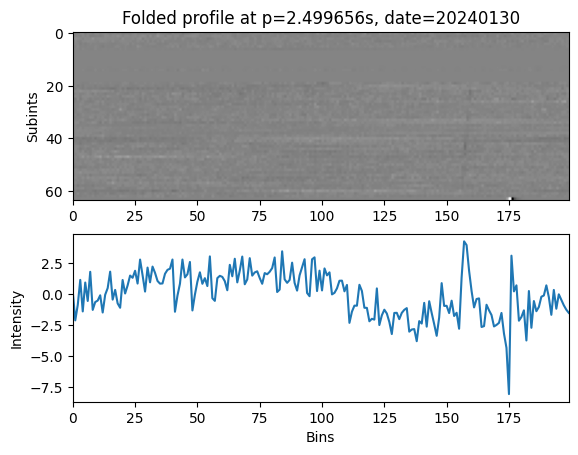

In [26]:
date_string = date.strftime("%Y%m%d")
# date_string = "20240130"
profile_name = f"profile_{np.round(ra,2)}_{np.round(dec,2)}_{date_string}.npz"
file_path = os.path.join(directory_name, profile_name)

data = np.load(file_path, allow_pickle = True)

# Assign the values to variables
subints = data['subints']
period = data['period']

# Close the file (optional, ensures resources are freed)
data.close()

plt.subplot(211)
plt.title(f"Folded profile at p={np.round(period,6)}s, date={date_string}")
plt.imshow(subints, cmap='Greys', aspect='auto')
plt.xlim(0,199)
plt.ylabel("Subints")
plt.subplot(212)
plt.plot(subints.sum(axis=0))
plt.xlabel("Bins")
plt.ylabel("Intensity")
plt.xlim(0,199)

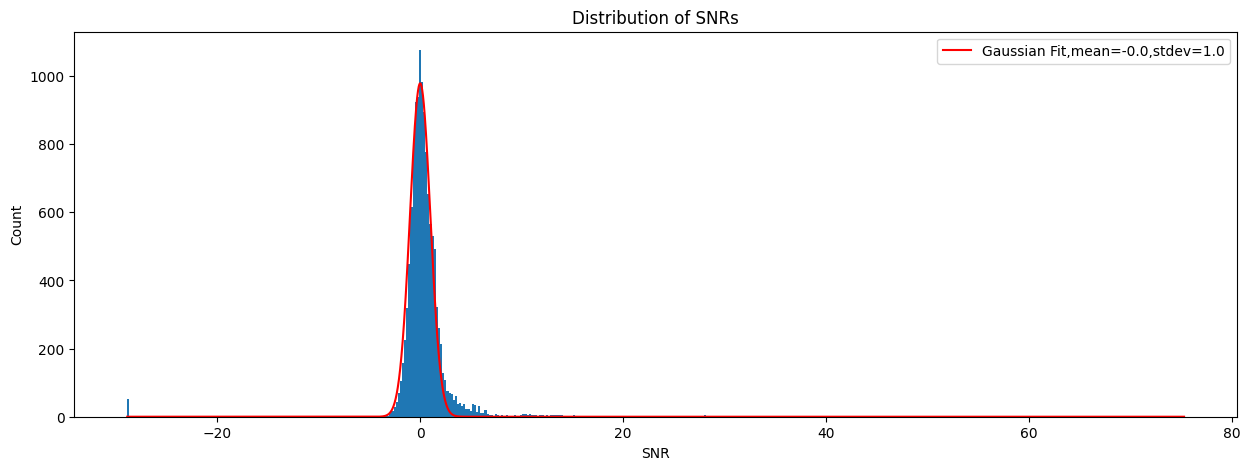

In [27]:
def gaussian_model(x, a, mu, sigma):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


from scipy.optimize import curve_fit



cur_pgram = pgram

fig, ax = plt.subplots(figsize=(15, 5))

snr_distrib = np.histogram(cur_pgram.snrs.max(axis=1), bins=500)
popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[500,1,3])
perr = np.sqrt(np.diag(pcov))

x = np.linspace(min(snr_distrib[1]), max(snr_distrib[1]), 10000)
ax.plot(x, gaussian_model(x, *popt), 'r-', label='Gaussian Fit,mean='+str(np.round(popt[1],2))+',stdev='+str(np.round(popt[2],2)))

ax.hist(cur_pgram.snrs.max(axis=1), bins=500)
ax.set_title("Distribution of SNRs")
ax.set_ylabel("Count")
ax.set_xlabel("SNR")
ax.legend()